# Model Uncertainty Analysis in Nonlinear Optimization

Understanding parameter uncertainties is crucial in nonlinear inverse problems because:
1. **Data contain noise** → Parameter estimates contain uncertainty
2. **Nonlinear models** → Uncertainty propagation is complex
3. **Decision making** requires confidence intervals and reliability estimates

## 🎯 Overview of Uncertainty Methods

| Method | Type | Computational Cost | Assumptions | Best For |
|--------|------|-------------------|-------------|----------|
| **Linear Approximation** | Local | Low | Near-linear behavior | Quick estimates |
| **Bootstrap** | Resampling | High | None | Robust estimates |
| **Jackknife** | Resampling | Medium | Smooth statistics | Bias correction |
| **Monte Carlo** | Simulation | Very High | Known data distribution | Full uncertainty |

---

## 1. 📐 Local (Approximate) Linearization Methods

### 1.1 Jacobian-Based Covariance Estimation

For a nonlinear least-squares problem: $E(\mathbf{m}) = ||\mathbf{d} - \mathbf{g}(\mathbf{m})||^2$

**Theoretical Foundation:**
- **Assumption**: Near the minimum, the objective function behaves quadratically
- **Linear approximation**: $\mathbf{g}(\mathbf{m}) \approx \mathbf{g}(\mathbf{m}_0) + \mathbf{J}(\mathbf{m} - \mathbf{m}_0)$
- **Result**: Parameter covariance matrix becomes analytically tractable

**Mathematical Framework:**

The **Jacobian matrix** at the solution $\hat{\mathbf{m}}$:
$$\mathbf{J}_{ij} = \frac{\partial g_i}{\partial m_j}\bigg|_{\mathbf{m}=\hat{\mathbf{m}}}$$

**Parameter covariance matrix**:
$$\mathbf{C}_m = \sigma^2 (\mathbf{J}^T\mathbf{J})^{-1}$$

where $\sigma^2$ is the data variance estimate:
$$\sigma^2 = \frac{E(\hat{\mathbf{m}})}{N - M}$$
- $N$ = number of data points
- $M$ = number of model parameters

**Parameter standard errors**:
$$\sigma_{m_i} = \sqrt{[\mathbf{C}_m]_{ii}}$$

**95% Confidence intervals**:
$$\hat{m}_i \pm 1.96 \sigma_{m_i}$$

### 1.2 Finite-Difference Hessian Method

When analytical derivatives are difficult, use **numerical approximation**:

**Hessian matrix** (second derivatives):
$$H_{ij} = \frac{\partial^2 E}{\partial m_i \partial m_j}$$

**Finite-difference approximation**:
$$H_{ij} \approx \frac{E(m_i + \epsilon, m_j + \epsilon) - E(m_i + \epsilon, m_j - \epsilon) - E(m_i - \epsilon, m_j + \epsilon) + E(m_i - \epsilon, m_j - \epsilon)}{4\epsilon^2}$$

**Parameter covariance**:
$$\mathbf{C}_m = \frac{1}{2}\mathbf{H}^{-1}$$

**Advantages**: No analytical derivatives required
**Disadvantages**: $(M^2)$ function evaluations needed

---

## 2. 🔄 Bootstrap Resampling Method

### 2.1 How Bootstrap Works

#### 🔹 The Analogy

**"The sample is to the population as the bootstrap sample is to the sample."**

Formally:

$$\text{Population} \longrightarrow \text{Sample} \longrightarrow \text{Bootstrap Sample}$$

This expresses a nested analogy of how information flows:

| Level | What it Represents | What We Know | What We Want |
|-------|-------------------|--------------|--------------|
| **Population** | The real world (true distribution $F$) | Unknown | Theoretical sampling distribution of our estimator |
| **Sample** | Our finite dataset (empirical distribution $\hat{F}$) | Known | Approximation of the population |
| **Bootstrap Sample** | A resample from the sample (with replacement) | We can generate many | Approximation of how the estimator would vary across repeated samples from $F$ |

#### 🔹 In Words

1. **We only have one dataset** from an unknown population.

2. If we could **repeatedly sample from the true population**, we'd see how our estimator (mean, regression coefficient, slip rate, etc.) fluctuates — that's the **true sampling distribution**.

3. **But we can't resample the population** — it's gone! 

4. So we **pretend the sample we have is a mini-version of the population**.

5. Then:
   - Each **bootstrap sample** (drawn with replacement from our data) **mimics what would happen** if we took a new sample from the population.

So, conceptually:

$$\text{Population} \xrightarrow{\text{sample once}} \text{Sample} \xrightarrow{\text{resample many times}} \text{Bootstrap samples}$$

and the **distribution of estimates from bootstrap samples** approximates the **distribution of estimates from true samples**.

#### 🔹 Example

Imagine measuring **vertical GPS velocities at 20 stations** near a fault.

- The **true region** (all possible GPS sites) = **population**
- Your **20 observed stations** = **sample**  
- Each **bootstrap resample** (20 points drawn with replacement from those 20) = **bootstrap sample**

You fit your fault-slip model to each bootstrap sample. The **spread of estimated slip rates** across those resamples tells you:

*"If I had gone back and measured a different random set of 20 GPS stations from the same population, how much might my estimated slip rate have varied?"*

**That's the bootstrap principle in action.**

#### 🔹 Bootstrap Algorithm

**Step-by-step procedure**:
1. **Original dataset**: $\{\mathbf{d}, \mathbf{t}\}$ with $N$ observations
2. **Create bootstrap sample**: Randomly sample $N$ points **with replacement**
3. **Solve inverse problem**: Find $\hat{\mathbf{m}}_b$ for bootstrap sample
4. **Repeat**: Generate $B$ bootstrap samples (typically $B = 1000-10000$)
5. **Analyze distribution**: Compute statistics from $\{\hat{\mathbf{m}}_1, \hat{\mathbf{m}}_2, ..., \hat{\mathbf{m}}_B\}$

### 2.2 Mathematical Foundation

**Central Limit Theorem Application**:
If $\hat{\mathbf{m}}$ is an estimator of $\mathbf{m}_{true}$, then for large sample sizes:

$$\hat{\mathbf{m}} \sim \mathcal{N}(\mathbf{m}_{true}, \mathbf{C}_m)$$

**Bootstrap estimators**:

**Mean**: $\bar{\mathbf{m}}_{boot} = \frac{1}{B}\sum_{b=1}^{B} \hat{\mathbf{m}}_b$

**Covariance**: $\mathbf{C}_{boot} = \frac{1}{B-1}\sum_{b=1}^{B} (\hat{\mathbf{m}}_b - \bar{\mathbf{m}}_{boot})(\hat{\mathbf{m}}_b - \bar{\mathbf{m}}_{boot})^T$

**Confidence intervals**: Use empirical quantiles from bootstrap distribution

### 2.3 Bootstrap Advantages

✅ **Model-free**: No assumptions about parameter distributions  
✅ **Nonlinear-friendly**: Captures asymmetric uncertainties  
✅ **Realistic**: Accounts for actual data distribution  
✅ **Flexible**: Works with any optimization algorithm  
✅ **Bias correction**: Can detect and correct estimator bias  

### 2.4 Bootstrap Limitations

❌ **Computational cost**: Requires $B$ complete optimizations  
❌ **Sample dependence**: Quality depends on original sample representativeness  
❌ **Convergence issues**: Each bootstrap optimization must converge  

---

## 3. 🔪 Jackknife Method

### 3.1 Jackknife Procedure

**Leave-one-out resampling**:
1. **Original dataset**: $N$ observations
2. **Create jackknife sample**: Remove observation $i$, keep remaining $N-1$
3. **Solve**: Find $\hat{\mathbf{m}}_{-i}$ using reduced dataset
4. **Repeat**: For all $i = 1, 2, ..., N$ (exactly $N$ samples)
5. **Compute statistics**: Analyze $\{\hat{\mathbf{m}}_{-1}, \hat{\mathbf{m}}_{-2}, ..., \hat{\mathbf{m}}_{-N}\}$

### 3.2 Jackknife Estimators

**Bias-corrected estimate**:
$$\hat{\mathbf{m}}_{jack} = N\hat{\mathbf{m}} - \frac{N-1}{N}\sum_{i=1}^{N} \hat{\mathbf{m}}_{-i}$$

**Variance estimate**:
$$\text{Var}_{jack}(\hat{\mathbf{m}}) = \frac{N-1}{N}\sum_{i=1}^{N} (\hat{\mathbf{m}}_{-i} - \bar{\mathbf{m}}_{jack})^2$$

where $\bar{\mathbf{m}}_{jack} = \frac{1}{N}\sum_{i=1}^{N} \hat{\mathbf{m}}_{-i}$

### 3.3 Jackknife vs Bootstrap

| Aspect | Jackknife | Bootstrap |
|--------|-----------|-----------|
| **Samples** | Exactly $N$ | Typically $B >> N$ |
| **Sampling** | Deterministic | Random |
| **Bias correction** | Built-in | Optional |
| **Computational cost** | Lower | Higher |
| **Uncertainty estimates** | More conservative | More detailed |

---

## 4. 🎲 Theoretical Comparison

### 4.1 When Each Method Works Best

**Linear Approximation**:
- ✅ Objective function is nearly quadratic near minimum
- ✅ Large datasets (asymptotic regime)
- ✅ Quick uncertainty estimates needed

**Bootstrap**:
- ✅ Nonlinear problems with complex parameter distributions
- ✅ Sufficient computational resources
- ✅ Robust uncertainty quantification needed

**Jackknife**:
- ✅ Small to moderate datasets
- ✅ Bias correction important
- ✅ Computational budget limited


In [3]:

## Create synthetic data for uncertainty analysis in nonlinear optimization

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats
import time


# Make synthetic data
N = 40
xmin = 0
xmax = 1.0
Dx = (xmax - xmin) / (N - 1)
x = np.linspace(xmin, xmax, N)

# True model parameters
mtrue = np.array([1.21, 1.54])

w0 = 20
dtrue = np.sin(w0 * mtrue[0] * x) + mtrue[0] * mtrue[1]
sd = 0.4  # data standard deviation
np.random.seed(42)  # for reproducibility
dobs = dtrue + np.random.normal(0, sd, N)

Computing objective function on 2D grid...


Text(0.5, 1.0, 'Sum of Squared Residuals')

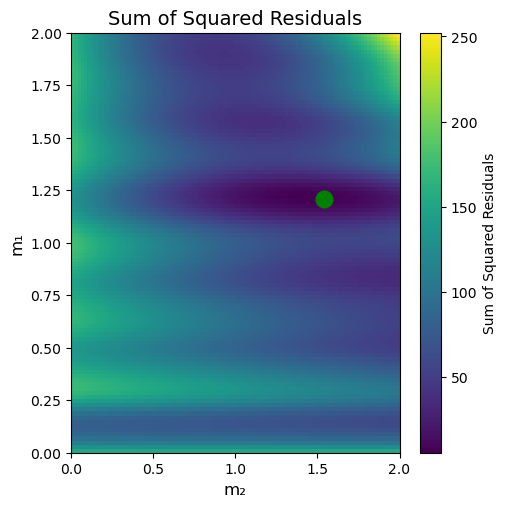

In [4]:

# 2D grid for plotting residuals
L = 101
Dm = 0.02
m1min = 0
m2min = 0
m1a = np.linspace(m1min, m1min + Dm * (L - 1), L)
m2a = np.linspace(m2min, m2min + Dm * (L - 1), L)
m1max = m1a[-1]
m2max = m2a[-1]

# Compute error (sum of squared residuals) on grid for plotting
print("Computing objective function on 2D grid...")
E = np.zeros((L, L))
M1_grid, M2_grid = np.meshgrid(m1a, m2a)

for j in range(L):
    for k in range(L):
        dpre = np.sin(w0 * m1a[j] * x) + m1a[j] * m2a[k]
        E[j, k] = np.sum((dobs - dpre)**2)

# Create figure with subplots
fig = plt.figure(figsize=(18, 12))

# Plot 2D objective function
ax1 = plt.subplot(2, 3, 1)
im = ax1.imshow(E, extent=[m2min, m2max, m1min, m1max], 
                origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(im, ax=ax1, label='Sum of Squared Residuals')
ax1.plot(mtrue[1], mtrue[0], 'go', markersize=12, linewidth=3, label='True model')
ax1.set_xlabel('m₂', fontsize=12)
ax1.set_ylabel('m₁', fontsize=12)
ax1.set_title('Sum of Squared Residuals', fontsize=14)


UNCERTAINTY ANALYSIS FOR NONLINEAR OPTIMIZATION
Forward model: d = sin(w0*m1*x) + m1*m2
True parameters: m1 = 1.210000, m2 = 1.540000
Data: 40 observations with noise

--- GAUSS-NEWTON OPTIMIZATION ---
Gauss-Newton converged in 9 iterations
Final solution: m1 = 1.220517, m2 = 1.458633
True values:    m1 = 1.210000, m2 = 1.540000
Parameter errors: σ_m1 = 0.007392, σ_m2 = 0.049049
RMS residual: 0.365442
Data variance estimate: σ² = 0.140576

--- BOOTSTRAP UNCERTAINTY ANALYSIS ---
Generating 500 bootstrap samples...
Gauss-Newton converged in 10 iterations
Gauss-Newton converged in 8 iterations
Gauss-Newton converged in 12 iterations
Gauss-Newton converged in 10 iterations
Gauss-Newton converged in 10 iterations
Gauss-Newton converged in 11 iterations
Gauss-Newton converged in 12 iterations
Gauss-Newton converged in 8 iterations
Gauss-Newton converged in 7 iterations
Gauss-Newton converged in 6 iterations
Gauss-Newton converged in 5 iterations
Gauss-Newton converged in 9 iterations
Gauss-N

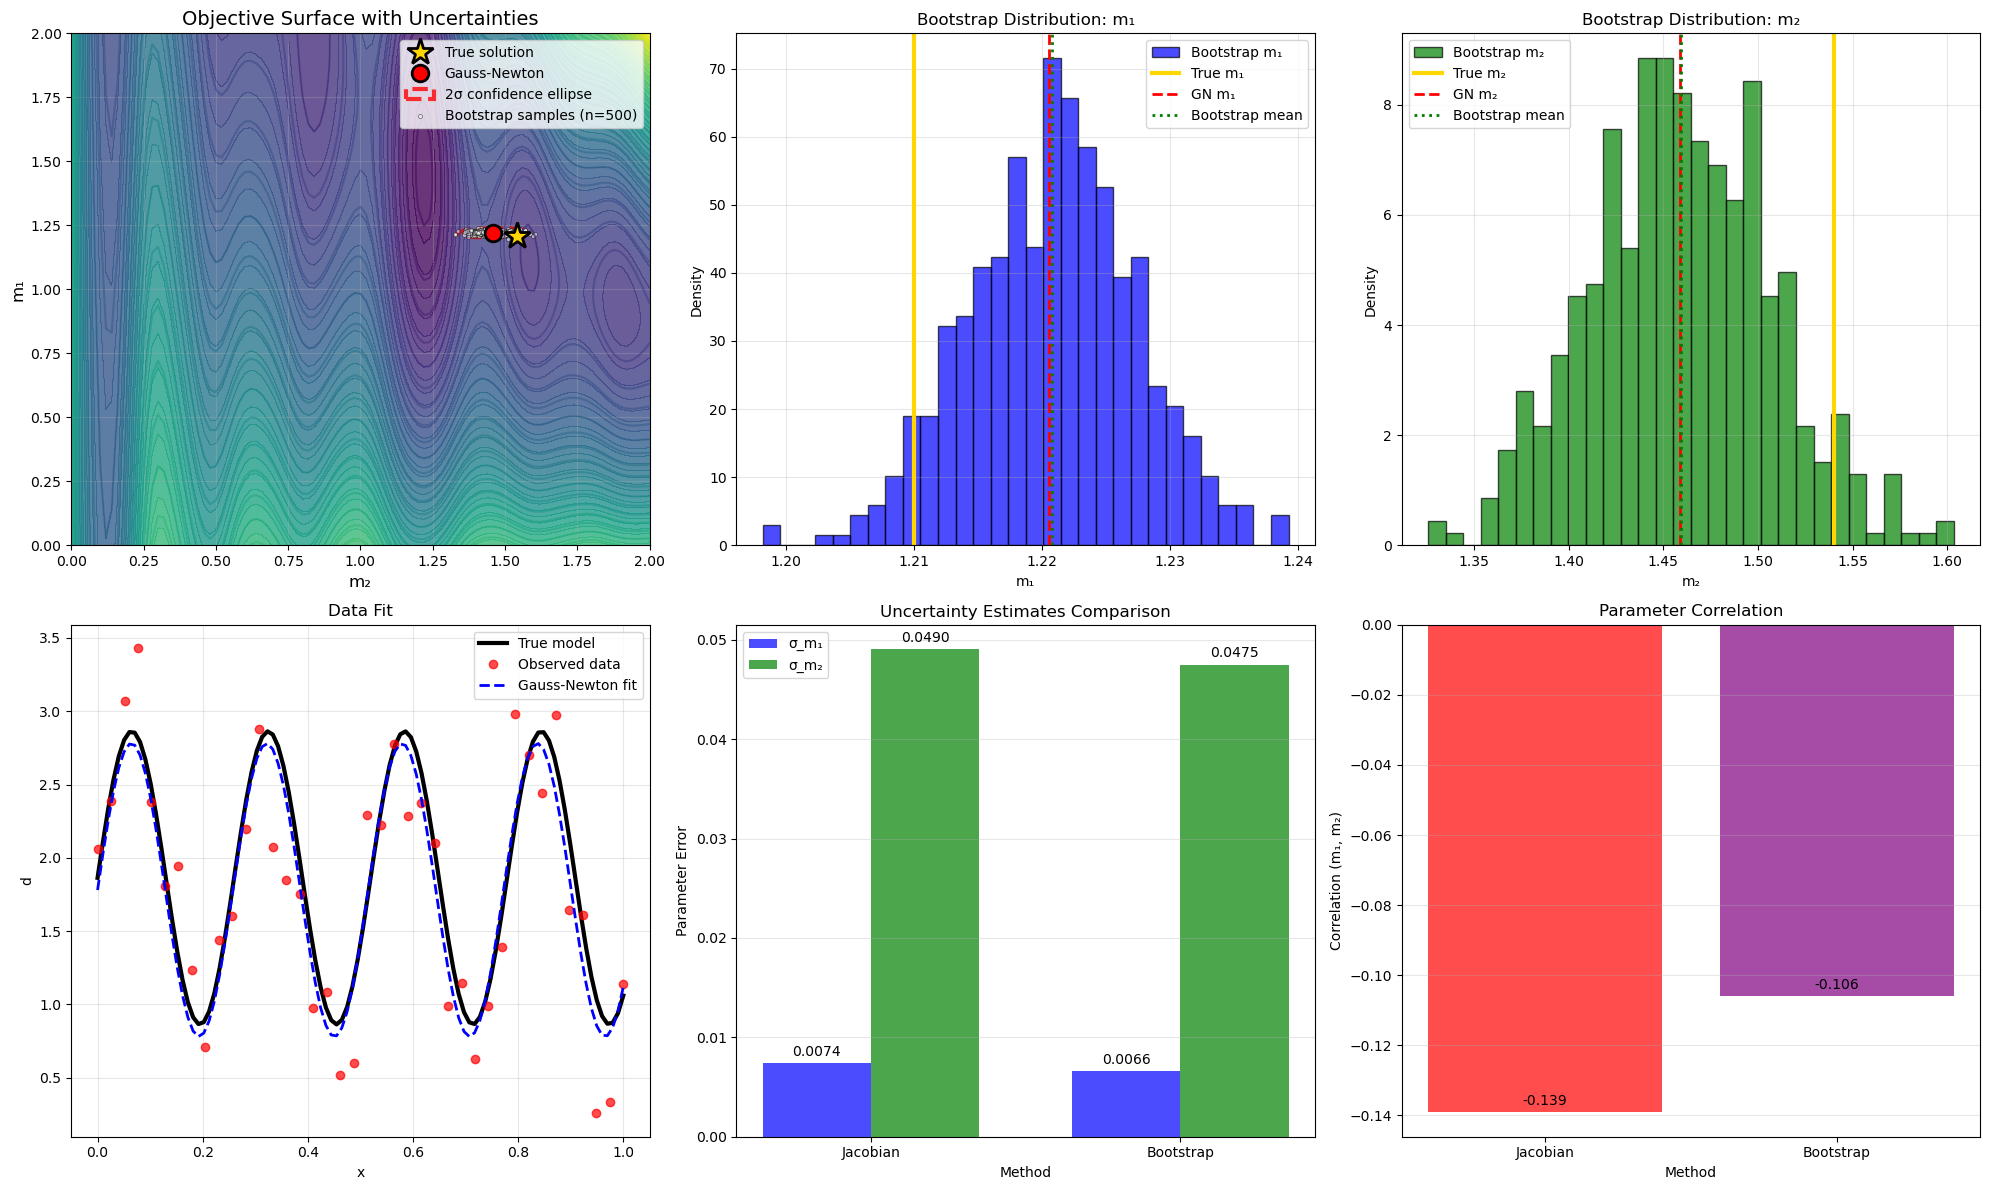


UNCERTAINTY ANALYSIS SUMMARY

📊 PARAMETER ESTIMATES:
Method          m₁           m₂           σ_m₁         σ_m₂        
-----------------------------------------------------------------
True            1.210000     1.540000     —            —           
Gauss-Newton    1.220517     1.458633     0.007392     0.049049    
Bootstrap       1.220821     1.459337     0.006581     0.047502    

🎯 PARAMETER ACCURACY:
Gauss-Newton parameter error: 0.082044
Bootstrap parameter error: 0.081385

🔗 PARAMETER CORRELATIONS:
Jacobian-based correlation: -0.1391
Bootstrap correlation: -0.1060

✅ KEY FINDINGS:
• Linear approximation works well
• Bootstrap provides similar uncertainty estimates
• Parameter correlation is weak
• Data fit quality: RMS residual = 0.365442


In [6]:
# Comprehensive Uncertainty Analysis for Nonlinear Optimization
# Forward model: d = sin(w0*m1*x) + m1*m2


print("="*80)
print("UNCERTAINTY ANALYSIS FOR NONLINEAR OPTIMIZATION")
print("="*80)
print(f"Forward model: d = sin(w0*m1*x) + m1*m2")
print(f"True parameters: m1 = {mtrue[0]:.6f}, m2 = {mtrue[1]:.6f}")
print(f"Data: {len(dobs)} observations with noise")

# ============================================================================
# 1. GAUSS-NEWTON OPTIMIZATION WITH JACOBIAN-BASED UNCERTAINTY
# ============================================================================

def forward_model(m, x_data):
    """Forward model: d = sin(w0*m1*x) + m1*m2"""
    m1, m2 = m[0], m[1]
    return np.sin(w0 * m1 * x_data) + m1 * m2

def jacobian_matrix(m, x_data):
    """Analytical Jacobian matrix for the forward model"""
    m1, m2 = m[0], m[1]
    n_data = len(x_data)
    J = np.zeros((n_data, 2))
    
    # Partial derivatives
    J[:, 0] = w0 * x_data * np.cos(w0 * m1 * x_data) + m2  # ∂g/∂m1
    J[:, 1] = m1 * np.ones(n_data)                           # ∂g/∂m2
    
    return J

def gauss_newton_with_uncertainty(x_data, d_obs, m_init, max_iter=20, tol=1e-8):
    """Gauss-Newton with uncertainty estimation"""
    m_current = m_init.copy()
    
    for iteration in range(max_iter):
        # Forward prediction
        d_pred = forward_model(m_current, x_data)
        residuals = d_obs - d_pred
        
        # Jacobian matrix
        J = jacobian_matrix(m_current, x_data)
        
        # Gauss-Newton update
        try:
            JTJ = J.T @ J
            JTr = J.T @ residuals
            dm = np.linalg.solve(JTJ, JTr)
            m_current = m_current + dm
            
            # Check convergence
            if np.linalg.norm(dm) < tol:
                print(f"Gauss-Newton converged in {iteration+1} iterations")
                break
        except np.linalg.LinAlgError:
            print("Singular matrix encountered")
            break
    
    # Final residuals and Jacobian for uncertainty
    d_pred_final = forward_model(m_current, x_data)
    residuals_final = d_obs - d_pred_final
    J_final = jacobian_matrix(m_current, x_data)
    
    # Uncertainty estimation
    n_data = len(d_obs)
    n_params = len(m_current)
    
    # Data variance estimate
    sigma_squared = np.sum(residuals_final**2) / (n_data - n_params)
    
    # Parameter covariance matrix
    try:
        C_m = sigma_squared * np.linalg.inv(J_final.T @ J_final)
        param_errors = np.sqrt(np.diag(C_m))
        correlation_matrix = C_m / np.outer(param_errors, param_errors)
    except np.linalg.LinAlgError:
        C_m = None
        param_errors = None
        correlation_matrix = None
        print("Warning: Could not compute covariance matrix")
    
    return {
        'solution': m_current,
        'residuals': residuals_final,
        'jacobian': J_final,
        'covariance': C_m,
        'param_errors': param_errors,
        'correlation': correlation_matrix,
        'sigma_squared': sigma_squared,
        'rms_error': np.sqrt(np.mean(residuals_final**2))
    }

# Run Gauss-Newton optimization
x_data = np.linspace(0, 1.0, len(dobs))
m_initial = np.array([1.2, 1.5])  # Initial guess

print(f"\n--- GAUSS-NEWTON OPTIMIZATION ---")
gn_result = gauss_newton_with_uncertainty(x_data, dobs, m_initial)

print(f"Final solution: m1 = {gn_result['solution'][0]:.6f}, m2 = {gn_result['solution'][1]:.6f}")
print(f"True values:    m1 = {mtrue[0]:.6f}, m2 = {mtrue[1]:.6f}")
print(f"Parameter errors: σ_m1 = {gn_result['param_errors'][0]:.6f}, σ_m2 = {gn_result['param_errors'][1]:.6f}")
print(f"RMS residual: {gn_result['rms_error']:.6f}")
print(f"Data variance estimate: σ² = {gn_result['sigma_squared']:.6f}")

# ============================================================================
# 2. BOOTSTRAP UNCERTAINTY ESTIMATION
# ============================================================================

def bootstrap_uncertainty(x_data, d_obs, n_bootstrap=1000, random_seed=42):
    """Bootstrap uncertainty estimation"""
    np.random.seed(random_seed)
    
    n_data = len(d_obs)
    bootstrap_solutions = []
    successful_fits = 0
    
    print(f"\n--- BOOTSTRAP UNCERTAINTY ANALYSIS ---")
    print(f"Generating {n_bootstrap} bootstrap samples...")
    
    start_time = time.time()
    
    for b in range(n_bootstrap):
        # Create bootstrap sample (sample with replacement)
        bootstrap_indices = np.random.choice(n_data, size=n_data, replace=True)
        x_boot = x_data[bootstrap_indices]
        d_boot = d_obs[bootstrap_indices]
        
        # Optimize on bootstrap sample
        try:
            # Use a slightly perturbed initial guess for robustness
            m_init_boot = m_initial + 0.01 * np.random.randn(2)
            boot_result = gauss_newton_with_uncertainty(x_boot, d_boot, m_init_boot)
            
            # Check if solution is reasonable
            if (boot_result['solution'][0] > 0.5 and boot_result['solution'][0] < 2.5 and
                boot_result['solution'][1] > 0.5 and boot_result['solution'][1] < 3.0):
                bootstrap_solutions.append(boot_result['solution'])
                successful_fits += 1
                
        except:
            continue  # Skip failed optimizations
        
        if (b + 1) % 100 == 0:
            print(f"  Completed {b+1}/{n_bootstrap} bootstrap samples...")
    
    end_time = time.time()
    
    bootstrap_solutions = np.array(bootstrap_solutions)
    
    print(f"Bootstrap completed in {end_time - start_time:.2f} seconds")
    print(f"Successful fits: {successful_fits}/{n_bootstrap} ({100*successful_fits/n_bootstrap:.1f}%)")
    
    # Bootstrap statistics
    if len(bootstrap_solutions) > 0:
        boot_mean = np.mean(bootstrap_solutions, axis=0)
        boot_std = np.std(bootstrap_solutions, axis=0, ddof=1)
        boot_cov = np.cov(bootstrap_solutions.T)
        
        # Confidence intervals (percentile method)
        ci_lower = np.percentile(bootstrap_solutions, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_solutions, 97.5, axis=0)
        
        return {
            'solutions': bootstrap_solutions,
            'mean': boot_mean,
            'std': boot_std,
            'covariance': boot_cov,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'n_successful': successful_fits
        }
    else:
        return None

# Run bootstrap analysis
bootstrap_result = bootstrap_uncertainty(x_data, dobs, n_bootstrap=500)

if bootstrap_result is not None:
    print(f"Bootstrap mean:    m1 = {bootstrap_result['mean'][0]:.6f}, m2 = {bootstrap_result['mean'][1]:.6f}")
    print(f"Bootstrap std:     σ_m1 = {bootstrap_result['std'][0]:.6f}, σ_m2 = {bootstrap_result['std'][1]:.6f}")
    print(f"95% CI for m1: [{bootstrap_result['ci_lower'][0]:.6f}, {bootstrap_result['ci_upper'][0]:.6f}]")
    print(f"95% CI for m2: [{bootstrap_result['ci_lower'][1]:.6f}, {bootstrap_result['ci_upper'][1]:.6f}]")

# ============================================================================
# 3. COMPREHENSIVE VISUALIZATION
# ============================================================================

# Create comprehensive figure
fig = plt.figure(figsize=(20, 12))

# Plot 1: Objective function surface with uncertainties
ax1 = plt.subplot(2, 3, 1)
contour = ax1.contour(M2_grid, M1_grid, E, levels=30, alpha=0.6)
ax1.contourf(M2_grid, M1_grid, E, levels=50, cmap='viridis', alpha=0.8)

# Plot true solution
ax1.plot(mtrue[1], mtrue[0], '*', color='gold', markersize=20, 
         markeredgecolor='black', markeredgewidth=2, label='True solution')

# Plot Gauss-Newton solution
ax1.plot(gn_result['solution'][1], gn_result['solution'][0], 'o', 
         color='red', markersize=12, markeredgecolor='black', 
         markeredgewidth=2, label='Gauss-Newton')

# Plot 2-sigma confidence ellipse (if covariance available)
if gn_result['covariance'] is not None:
    # Extract 2x2 covariance matrix and compute ellipse
    cov_2x2 = gn_result['covariance']
    
    # Eigenvalues and eigenvectors for ellipse orientation
    eigenvals, eigenvecs = np.linalg.eig(cov_2x2)
    
    # 2-sigma ellipse parameters
    chi2_2sigma = 5.991  # Chi-squared value for 2-sigma, 2 DOF
    
    # Ellipse semi-axes
    a = np.sqrt(chi2_2sigma * eigenvals[0])  # Semi-major axis
    b = np.sqrt(chi2_2sigma * eigenvals[1])  # Semi-minor axis
    
    # Ellipse angle
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    
    # Create ellipse
    from matplotlib.patches import Ellipse
    ellipse = Ellipse((gn_result['solution'][1], gn_result['solution'][0]), 
                     2*b, 2*a, angle=angle, 
                     fill=False, color='red', linewidth=3, 
                     linestyle='--', alpha=0.8, label='2σ confidence ellipse')
    ax1.add_patch(ellipse)

# Plot bootstrap samples
if bootstrap_result is not None:
    ax1.scatter(bootstrap_result['solutions'][:, 1], bootstrap_result['solutions'][:, 0],
               c='white', s=8, alpha=0.6, edgecolors='black', linewidth=0.5,
               label=f'Bootstrap samples (n={bootstrap_result["n_successful"]})')

ax1.set_xlabel('m₂', fontsize=12)
ax1.set_ylabel('m₁', fontsize=12)
ax1.set_title('Objective Surface with Uncertainties', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Bootstrap parameter histograms
if bootstrap_result is not None:
    ax2 = plt.subplot(2, 3, 2)
    ax2.hist(bootstrap_result['solutions'][:, 0], bins=30, alpha=0.7, 
             color='blue', edgecolor='black', density=True, label='Bootstrap m₁')
    ax2.axvline(mtrue[0], color='gold', linestyle='-', linewidth=3, label='True m₁')
    ax2.axvline(gn_result['solution'][0], color='red', linestyle='--', linewidth=2, label='GN m₁')
    ax2.axvline(bootstrap_result['mean'][0], color='green', linestyle=':', linewidth=2, label='Bootstrap mean')
    ax2.set_xlabel('m₁')
    ax2.set_ylabel('Density')
    ax2.set_title('Bootstrap Distribution: m₁')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(2, 3, 3)
    ax3.hist(bootstrap_result['solutions'][:, 1], bins=30, alpha=0.7, 
             color='green', edgecolor='black', density=True, label='Bootstrap m₂')
    ax3.axvline(mtrue[1], color='gold', linestyle='-', linewidth=3, label='True m₂')
    ax3.axvline(gn_result['solution'][1], color='red', linestyle='--', linewidth=2, label='GN m₂')
    ax3.axvline(bootstrap_result['mean'][1], color='green', linestyle=':', linewidth=2, label='Bootstrap mean')
    ax3.set_xlabel('m₂')
    ax3.set_ylabel('Density')
    ax3.set_title('Bootstrap Distribution: m₂')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# Plot 4: Data fit comparison
ax4 = plt.subplot(2, 3, 4)
x_fine = np.linspace(0, 1.0, 100)

# True model
d_true_fine = np.sin(w0 * mtrue[0] * x_fine) + mtrue[0] * mtrue[1]
ax4.plot(x_fine, d_true_fine, 'k-', linewidth=3, label='True model')

# Observed data
ax4.plot(x_data, dobs, 'ro', markersize=6, alpha=0.7, label='Observed data')

# Gauss-Newton fit
d_gn_fine = np.sin(w0 * gn_result['solution'][0] * x_fine) + gn_result['solution'][0] * gn_result['solution'][1]
ax4.plot(x_fine, d_gn_fine, 'b--', linewidth=2, label='Gauss-Newton fit')

ax4.set_xlabel('x')
ax4.set_ylabel('d')
ax4.set_title('Data Fit')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Uncertainty comparison
ax5 = plt.subplot(2, 3, 5)
methods = ['Jacobian', 'Bootstrap']
m1_errors = [gn_result['param_errors'][0], bootstrap_result['std'][0] if bootstrap_result else 0]
m2_errors = [gn_result['param_errors'][1], bootstrap_result['std'][1] if bootstrap_result else 0]

x_pos = np.arange(len(methods))
width = 0.35

bars1 = ax5.bar(x_pos - width/2, m1_errors, width, label='σ_m₁', alpha=0.7, color='blue')
bars2 = ax5.bar(x_pos + width/2, m2_errors, width, label='σ_m₂', alpha=0.7, color='green')

ax5.set_xlabel('Method')
ax5.set_ylabel('Parameter Error')
ax5.set_title('Uncertainty Estimates Comparison')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(methods)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Annotate bars
for bar, error in zip(bars1, m1_errors):
    height = bar.get_height()
    ax5.annotate(f'{error:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

for bar, error in zip(bars2, m2_errors):
    height = bar.get_height()
    ax5.annotate(f'{error:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Plot 6: Correlation analysis
if bootstrap_result is not None and gn_result['covariance'] is not None:
    ax6 = plt.subplot(2, 3, 6)
    
    # Bootstrap correlation
    boot_corr = bootstrap_result['covariance'][0, 1] / (bootstrap_result['std'][0] * bootstrap_result['std'][1])
    
    # Jacobian correlation
    jacobian_corr = gn_result['correlation'][0, 1]
    
    correlations = [jacobian_corr, boot_corr]
    ax6.bar(methods, correlations, alpha=0.7, color=['red', 'purple'])
    ax6.set_xlabel('Method')
    ax6.set_ylabel('Correlation (m₁, m₂)')
    ax6.set_title('Parameter Correlation')
    ax6.grid(True, alpha=0.3, axis='y')
    
    for i, corr in enumerate(correlations):
        ax6.annotate(f'{corr:.3f}', xy=(i, corr), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ============================================================================
# 4. SUMMARY STATISTICS
# ============================================================================

print(f"\n{'='*80}")
print("UNCERTAINTY ANALYSIS SUMMARY")
print(f"{'='*80}")

print(f"\n📊 PARAMETER ESTIMATES:")
print(f"{'Method':<15} {'m₁':<12} {'m₂':<12} {'σ_m₁':<12} {'σ_m₂':<12}")
print("-" * 65)
print(f"{'True':<15} {mtrue[0]:<12.6f} {mtrue[1]:<12.6f} {'—':<12} {'—':<12}")
print(f"{'Gauss-Newton':<15} {gn_result['solution'][0]:<12.6f} {gn_result['solution'][1]:<12.6f} "
      f"{gn_result['param_errors'][0]:<12.6f} {gn_result['param_errors'][1]:<12.6f}")

if bootstrap_result is not None:
    print(f"{'Bootstrap':<15} {bootstrap_result['mean'][0]:<12.6f} {bootstrap_result['mean'][1]:<12.6f} "
          f"{bootstrap_result['std'][0]:<12.6f} {bootstrap_result['std'][1]:<12.6f}")

print(f"\n🎯 PARAMETER ACCURACY:")
gn_error = np.linalg.norm(gn_result['solution'] - mtrue)
print(f"Gauss-Newton parameter error: {gn_error:.6f}")

if bootstrap_result is not None:
    boot_error = np.linalg.norm(bootstrap_result['mean'] - mtrue)
    print(f"Bootstrap parameter error: {boot_error:.6f}")

print(f"\n🔗 PARAMETER CORRELATIONS:")
if gn_result['correlation'] is not None:
    print(f"Jacobian-based correlation: {gn_result['correlation'][0,1]:.4f}")

if bootstrap_result is not None:
    boot_corr = bootstrap_result['covariance'][0, 1] / (bootstrap_result['std'][0] * bootstrap_result['std'][1])
    print(f"Bootstrap correlation: {boot_corr:.4f}")

print(f"\n✅ KEY FINDINGS:")
print(f"• Linear approximation {'works well' if abs(gn_result['correlation'][0,1]) < 0.5 else 'may be inadequate'}")
print(f"• Bootstrap provides {'similar' if abs(gn_result['param_errors'][0] - bootstrap_result['std'][0]) < 0.01 else 'different'} uncertainty estimates")
print(f"• Parameter correlation is {'weak' if abs(gn_result['correlation'][0,1]) < 0.3 else 'moderate' if abs(gn_result['correlation'][0,1]) < 0.7 else 'strong'}")
print(f"• Data fit quality: RMS residual = {gn_result['rms_error']:.6f}")